注入必要的库

In [1]:
# -*- coding:utf-8 -*-
from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import os 
import random
import csv
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, MaxPooling2D, Conv2D
from keras.regularizers import l2
from keras.utils.np_utils import to_categorical
from keras.optimizers import RMSprop, SGD
from keras.callbacks import  Callback,EarlyStopping
from keras.layers.normalization import BatchNormalization
%matplotlib inline

Using TensorFlow backend.


探索数据

编号:754
标签: Cat


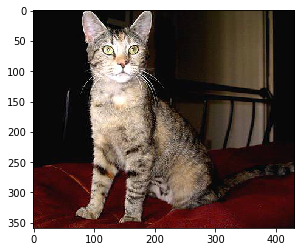

分辨率是:(431, 359)


In [2]:
train_path = 'train/'
test_path = 'test/'
row =120
col =120

file_name = os.listdir(train_path)
i = random.randint(0,len(file_name))

print ('编号:{}'.format(i))
if 'cat' in file_name[i]: 
    print ('标签: Cat')
    
elif 'dog' in file_name[i]:
    print ('标签: Dog')
    
img = Image.open(train_path+file_name[i]) 
plt.imshow(img)
plt.show()
print ('分辨率是:{}'.format(img.size))

统计图片信息

In [3]:
x_images = []
y_images = []

for i in os.listdir(train_path):
    i = train_path+i
    img = Image.open(i)
    x_images.append(img.size[0])
    y_images.append(img.size[1])

可视化统计信息

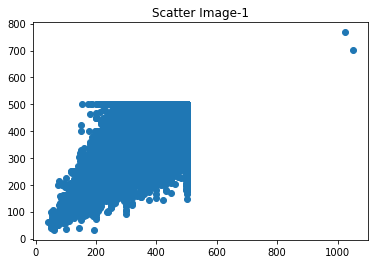

In [4]:
# print  (show_train.keys())
plt.title('Scatter Image-1')
plt.scatter(x_images,y_images)

从上图可以看出数据集中存在异常值，对数据集进行处理，删除异常值和不满足条件的数据集

In [5]:
train_images = []
x_images = []
y_images = []
for i in os.listdir(train_path):
    i = train_path+i
    img = Image.open(i)
    if img.size[0] < row or img.size[1] <col:
        continue
    elif img.size[0] > 600 and img.size[1] > 600:
        continue
    x_images.append(img.size[0])
    y_images.append(img.size[1])
    train_images.append(i)    

输出经过数据清洗后的数据分布图

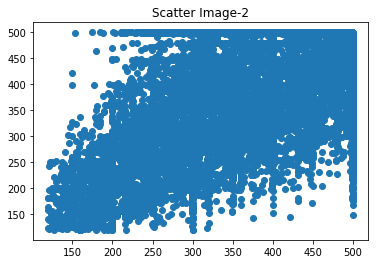

In [6]:
plt.title('Scatter Image-2')
plt.scatter(x_images,y_images)

输出目前的数据总数

In [7]:
len_train=len(train_images)
print ('The Sum of Train images:', len(train_images))

('The Sum of Train images:', 24586)


将原来的数据集打乱顺序

In [8]:
random.shuffle(train_images)

存储标签

('The Sum of Labels :', 24586)


([<matplotlib.patches.Wedge at 0x7f58abfdda10>,
  <matplotlib.text.Text at 0x7f58abffa110>])

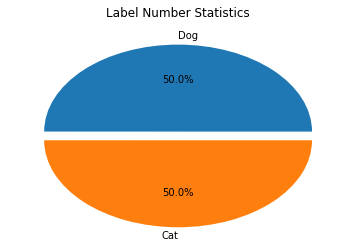

In [9]:
labels=[]
n = 0
m = 0
for i in train_images:
    if 'dog' in i:
        n = n + 1
        labels.append(1)
    elif 'cat' in i:
        m = m + 1
        labels.append(0)
print ('The Sum of Labels :', len(labels))
plt.title('Label Number Statistics')
data = np.array([n,m])
plt.pie(data,explode = [0, .1], labels=['Dog','Cat'],autopct='%1.1f%%')

数据进行格式转换，使数据大小统一，并随机输出一张图片

In [10]:
def resize_image(path_name):
    image = Image.open(path_name) 
    image = image.resize((row,col))
    return image

new_train_images = np.ndarray((len_train,row,col,3), dtype = np.uint8)

for i ,path_name in enumerate(train_images):
    new_train_image = resize_image(path_name)
    new_train_images[i]= np.array(new_train_image, dtype = np.uint8)




随机输出一张分辨率转换后的图片。


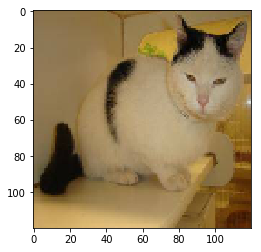

In [11]:
print ('随机输出一张分辨率转换后的图片。')
i = random.randint(0,len(new_train_images)) 
plt.imshow(new_train_images[i])
plt.show()

拆分训练数据集

In [12]:
#new_train_images =  new_train_images[:400]
#labels = labels[:400]
X_train, X_test, y_train, y_test =train_test_split(new_train_images , labels, test_size=0.2, random_state=42)
print ('New Sum of Train images:', len(X_train))
print ('New Sum of Test images:', len(X_test))

('New Sum of Train images:', 19668)
('New Sum of Test images:', 4918)


建立训练模型

In [40]:
model = Sequential()


model.add(Conv2D(32, (3, 3),padding='same',input_shape=(row,col,3), activation='relu'))
model.add(Conv2D(32,(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3),padding='same', activation='relu'))
model.add(Conv2D(64,(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3),padding='same', activation='relu'))
model.add(Conv2D(128,(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))


model.add(Dense(1))
model.add(Activation('sigmoid'))


model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=1e-4), metrics=['accuracy'])

print ('Model is Generated!')

Model is Generated!


对模型进行训练

In [42]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.acc = []
        self.val_acc = []

        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))

history = LossHistory()
   
model.fit(X_train, y_train, epochs=15, batch_size=8 ,callbacks=[history] , validation_split=0.2)
model.fit(X_train, y_train, epochs=15, batch_size=200 ,callbacks=[history] , validation_split=0.2)

Train on 15734 samples, validate on 3934 samples
Epoch 1/15
15734/15734 [==============================] - 123s - loss: 0.6186 - acc: 0.6618 - val_loss: 0.6531 - val_acc: 0.7034
Epoch 2/15
15734/15734 [==============================] - 122s - loss: 0.5451 - acc: 0.7396 - val_loss: 0.5061 - val_acc: 0.7555
Epoch 3/15
15734/15734 [==============================] - 122s - loss: 0.4966 - acc: 0.7774 - val_loss: 0.4742 - val_acc: 0.7951
Epoch 4/15
15734/15734 [==============================] - 123s - loss: 0.4567 - acc: 0.8055 - val_loss: 0.5382 - val_acc: 0.7877
Epoch 5/15
15734/15734 [==============================] - 123s - loss: 0.4236 - acc: 0.8260 - val_loss: 0.4132 - val_acc: 0.8096
Epoch 6/15
15734/15734 [==============================] - 123s - loss: 0.3966 - acc: 0.8436 - val_loss: 0.4619 - val_acc: 0.8388
Epoch 7/15
15734/15734 [==============================] - 123s - loss: 0.3885 - acc: 0.8530 - val_loss: 0.3972 - val_acc: 0.8327
Epoch 8/15
15734/15734 [========================

### 可视化Loss和ACC

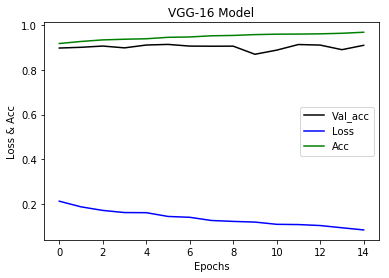

In [43]:
loss = history.losses
acc = history.acc
val_acc = history.val_acc


plt.xlabel('Epochs')
plt.ylabel('Loss & Acc')
plt.title('VGG-16 Model')

plt.plot(val_acc, 'black', label='Val_acc')
plt.plot(loss, 'blue', label='Loss')
plt.plot(acc, 'green', label='Acc')

plt.legend()
plt.show()